In [53]:
#needed to import qke procedures
import sys
from pathlib import Path

main_dir = str(Path().resolve().parent)
sys.path.insert(1, main_dir)

In [34]:
#scikit learn and tools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from qiskit_algorithms.utils import algorithm_globals

#set the seed(s)
np.random.seed(123)
algorithm_globals.random_seed = 123

#load dataset with panda
#data are scaled outside the notebook
env = pd.read_csv('../data/env.sel3.scaled.csv') 
#take a look of the dataset

print(f'DESCRIBE DATASET')
display(env.describe() )


#DEFINE design matrix
#slice dataset
f_rate = 0.05
env_slice = env.sample(frac=f_rate)

Y = env_slice['occupancy']
#X = env[['illuminance', 'blinds','lamps','co', 'rh', 'co2', 'temp']]
X = env_slice[['illuminance', 'blinds','lamps','rh', 'co2', 'temp']]

print(f'HEAD')
display(X.head())

DESCRIBE DATASET


,illuminance,blinds,lamps,rh,co2,temp,occupancy
count,2865.000000,2865.000000,2865.000000,2865.000000,2865.000000,2865.000000,2865.000000
mean,0.333425,2.518369,1.873848,1.852158,0.799182,1.270298,-0.130192
std,0.328082,1.169630,1.537233,0.645917,0.653629,0.715849,0.991662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.052071,3.141593,0.000000,1.533741,0.244120,0.659075,-1.000000
50%,0.310495,3.141593,3.141593,1.996120,0.586569,1.131413,-1.000000
75%,0.443564,3.141593,3.141593,2.261947,1.293940,1.790488,1.000000
max,3.141593,3.141593,3.141593,3.141593,3.141593,3.141593,1.000000


HEAD


,illuminance,blinds,lamps,rh,co2,temp
1618,0.312424,3.141593,3.141593,2.158032,1.134938,0.629783
610,0.842772,3.141593,3.141593,0.600125,0.274742,1.980888
1667,0.015428,3.141593,0.000000,2.349750,0.874522,0.659075
2481,0.289281,0.000000,3.141593,2.404527,1.192528,0.252645
2638,0.190926,3.141593,0.000000,2.138700,1.106006,0.849475


In [43]:
#split design matrix (25% of the design matrix used for test)
X_train, X_test, y_train, y_test = train_test_split(X, Y)
NUM_QUBIT =  X_train.shape[1]
#sanity check
print(f'TRAIN***** {X_train.shape}')
print(f'TEST***** {X_test.shape}')
print(f'Number of Qbit:  {NUM_QUBIT}')

TRAIN***** (107, 6)
TEST***** (36, 6)
Number of Qbit:  6


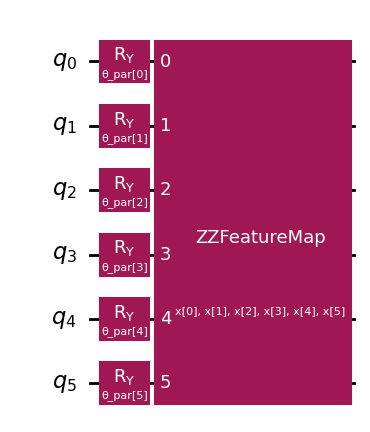

In [44]:
#get the feature mao
from qke.TrainableCircuits import TrainableCircuits

qc_trainable = TrainableCircuits.zzfm(n_wire=NUM_QUBIT)

fm = qc_trainable.qc
training_params = qc_trainable.training_parameters


fm.draw('mpl')

In [45]:
#define the trainable kernel
from qiskit_machine_learning.kernels import TrainableFidelityStatevectorKernel

q_kernel = TrainableFidelityStatevectorKernel(feature_map=fm, training_parameters=training_params)

In [46]:
#get the optimized kernel
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss

#define the callback
from qke.QKCallback import QKCallback
my_callback = QKCallback()


spsa_opt = SPSA(maxiter=20, learning_rate=0.03, perturbation=0.01, termination_checker=my_callback.callback)
loss_func = SVCLoss(C=1.0)

#one initial point per trainable parameter
#init_point=[np.pi/2]
init_point = np.random.uniform(size=NUM_QUBIT)

qk_trainer = QuantumKernelTrainer(quantum_kernel=q_kernel, loss=loss_func, initial_point= init_point, optimizer=spsa_opt)
qkt_results = qk_trainer.fit(X_train, y_train)

optimized_kernel = qkt_results.quantum_kernel

**********************
Print callback. Iteration 1
Number of function evaluations: 2
The paramenters: [0.97022951 0.75731795 0.18726914 0.73977139 0.79891553 0.13653031]
The function value: 47.84008022596255
The stepsize: 0.00020025243082683958
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 2
Number of function evaluations: 4
The paramenters: [0.93668098 0.79086648 0.15372061 0.70622286 0.83246406 0.17007884]
The function value: 47.840004564569185
The stepsize: 0.08217677898936988
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 3
Number of function evaluations: 6
The paramenters: [ 1.10542793  0.95961343 -0.01502634  0.53747591  1.00121101  0.00133189]
The function value: 47.79820175899454
The stepsize: 0.4133439311117796
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 4
Number of function evaluations: 8
The

In [47]:
from qiskit_machine_learning.algorithms.classifiers import QSVC
qsvc = QSVC(quantum_kernel=optimized_kernel)

In [48]:
#trainingprediction...
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.trainable_fidelity_statevector_kernel.TrainableFidelityStatevectorKernel object at 0x7959bb346e10>,
     random_state=123, shrinking=True, tol=0.001, verbose=False)

In [51]:
from sklearn.metrics import accuracy_score

#result...
predictions = qsvc.predict(X_test)
score = accuracy_score(predictions, y_test)

print(f'*******SCORE: {score}')


*******SCORE: 0.5


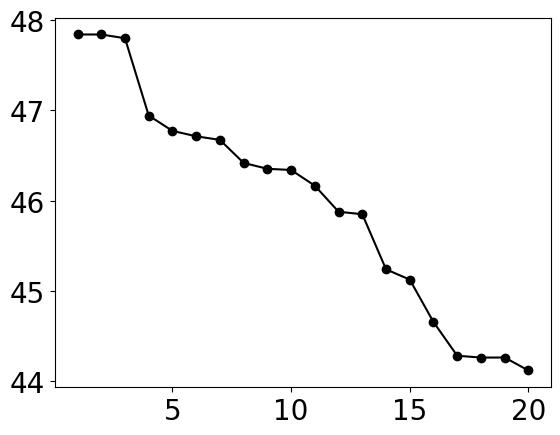

In [52]:
#plot data
my_callback.plot_data()